In [10]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
from tensorflow.keras.utils import plot_model

In [11]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [12]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [13]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Generator:

In [14]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Example:

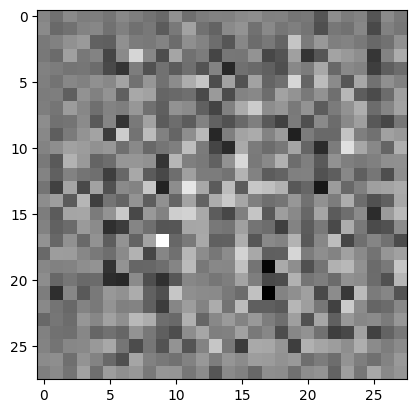

In [6]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

Discriminator:

In [15]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Example:

In [8]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00063696]], shape=(1, 1), dtype=float32)


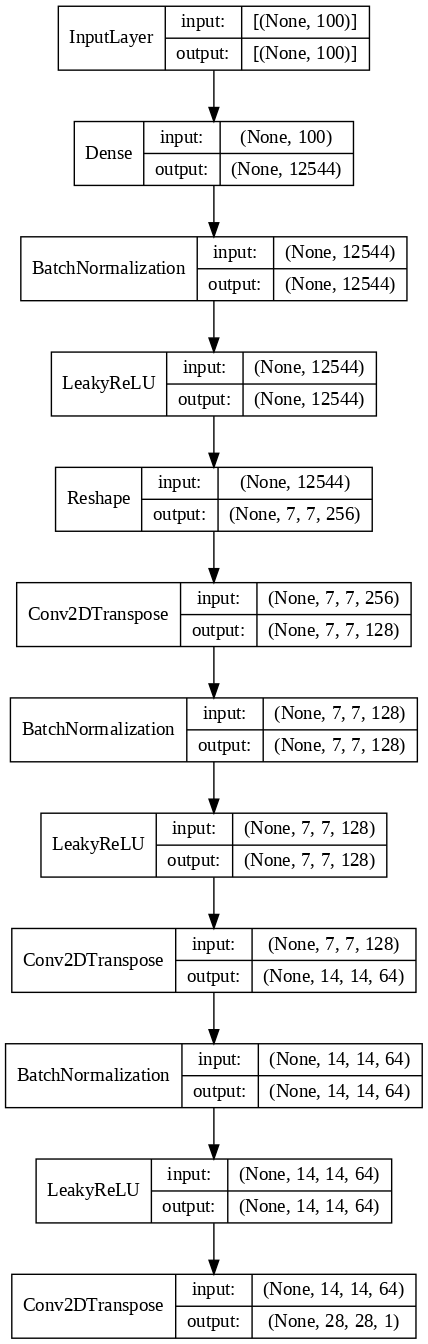

In [26]:
# Plot Generator Architecture
import pydot

plot_model(generator, to_file='generator_architecture.png', show_shapes=True, show_layer_names=False, rankdir = 'TB',dpi=100)


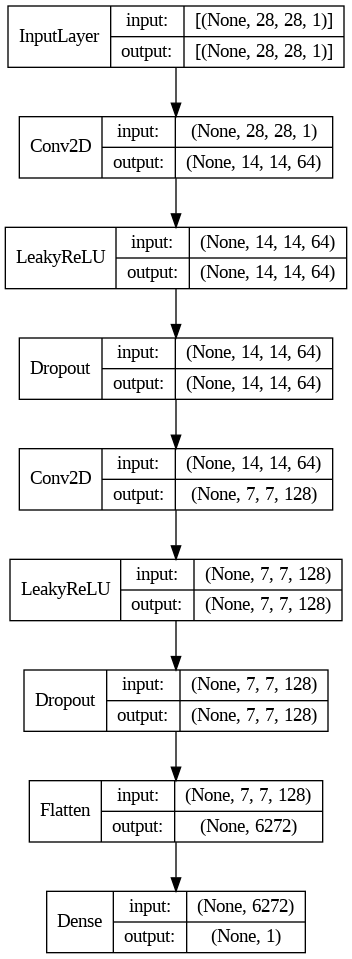

In [27]:
# Plot Discriminator Architecture
plot_model(discriminator, to_file='discriminator_architecture.png', show_shapes=True, show_layer_names=False)

**Loss functions and optimizers**:

In [16]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # returns a method to calculate cross entropy loss

Discriminator Loss:

In [17]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

Generator Loss:

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

Optimizers:

In [19]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Checkpoint:

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Training parameters:

In [21]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [22]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [23]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  generate_images(generator,seed)

In [24]:
def generate_images(model, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('dc_gan_results.png')
  plt.show()

Training:

Time for epoch 1 is 17.49555253982544 sec
Time for epoch 2 is 10.211692094802856 sec
Time for epoch 3 is 10.378509759902954 sec
Time for epoch 4 is 10.577101945877075 sec
Time for epoch 5 is 10.705441236495972 sec
Time for epoch 6 is 10.922720909118652 sec
Time for epoch 7 is 11.045701265335083 sec
Time for epoch 8 is 11.070739984512329 sec
Time for epoch 9 is 11.285451173782349 sec
Time for epoch 10 is 11.44585108757019 sec
Time for epoch 11 is 11.255857706069946 sec
Time for epoch 12 is 11.158235549926758 sec
Time for epoch 13 is 11.294477224349976 sec
Time for epoch 14 is 11.100161790847778 sec
Time for epoch 15 is 11.300869941711426 sec
Time for epoch 16 is 11.185476064682007 sec
Time for epoch 17 is 11.204371452331543 sec
Time for epoch 18 is 11.210135698318481 sec
Time for epoch 19 is 11.193904399871826 sec
Time for epoch 20 is 11.184868097305298 sec
Time for epoch 21 is 11.182386636734009 sec
Time for epoch 22 is 11.216108322143555 sec
Time for epoch 23 is 11.195308446884155 sec

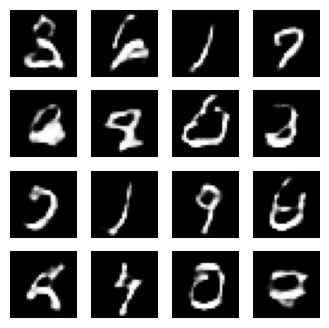

In [ ]:
train(train_dataset, EPOCHS)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [ ]:
generator.save('mnist_gen.keras')

In [ ]:
discriminator.save('mnist_dis.keras')

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [33]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.stats import entropy
from skimage.transform import resize

x_test = (test_images.astype(np.float32) - 127.5) / 127.5  # Normalize to [-1, 1]
x_test = np.expand_dims(x_test, axis=-1)  # Add channel dimension

# Load the trained generator and discriminator models
generator = load_model('mnist_gen.keras')
discriminator = load_model('mnist_dis.keras')

# Generate fake labels for discriminator evaluation
fake_labels = np.zeros(len(x_test))

# Evaluate discriminator on real images
real_predictions = discriminator.predict(x_test)
real_labels = np.ones(len(x_test))

# Generate fake images using the generator
fake_images = generator.predict(np.random.normal(0, 1, (len(x_test), 100)))
fake_predictions = discriminator.predict(fake_images)

# Apply threshold to discriminator's predictions
threshold = 0.5  # Adjust threshold as needed
real_predictions = (real_predictions > threshold).astype(int)
fake_predictions = (fake_predictions > threshold).astype(int)

# Combine real and fake predictions and labels
all_predictions = np.concatenate([real_predictions, fake_predictions])
all_labels = np.concatenate([real_labels, fake_labels])

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, np.round(all_predictions))
precision = precision_score(all_labels, np.round(all_predictions), average='binary')
recall = recall_score(all_labels, np.round(all_predictions), average='binary')
f1 = f1_score(all_labels, np.round(all_predictions), average='binary')

print(f'Discriminator Accuracy: {accuracy}')
print(f'Discriminator Precision: {precision}')
print(f'Discriminator Recall: {recall}')
print(f'Discriminator F1 Score: {f1}')

def calculate_inception_score(images):
    inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg')
    resized_images = np.array([resize(image, (299, 299, 3)) for image in images])
    preprocessed_images = preprocess_input(resized_images)
    preds = inception_model.predict(preprocessed_images, batch_size=32)
    p_yx = np.exp(preds) / np.exp(preds).sum(axis=1, keepdims=True)
    p_y = p_yx.mean(axis=0)
    kl_divs = [entropy(p_y, p_yx[i]) for i in range(len(images))]
    is_score = np.exp(np.mean(kl_divs)+2)
    return is_score

# Generate images using the generator in batches
n=100
batch_size = 32  # Define the batch size
num_batches = len(x_test[:n]) // batch_size
generated_images = []

for i in range(num_batches):
    # Generate noise for the batch
    noise = np.random.normal(0, 1, (batch_size, 100))  # Assuming latent vector size is 100
    batch_generated_images = generator.predict(noise)
    generated_images.append(batch_generated_images)

generated_images = np.concatenate(generated_images, axis=0)

# Evaluate the generated images using Inception Score
is_score = calculate_inception_score(generated_images)
print("After Hyperparameter training, with best model")
print(f'Inception Score is: {is_score}')


313/313 [==============================] - 5s 16ms/step
Discriminator Accuracy: 0.67845
Discriminator Precision: 0.8110510719888443
Discriminator Recall: 0.4653
Discriminator F1 Score: 0.5913452373387559
3/3 [==============================] - 23s 7s/step
After Hyperparameter training, with best model
Inception Score is: 7.414308373172685


In [ ]:
def generate_and_evaluate(generator):
    num_examples_to_generate = 16
    seed = tf.random.normal([num_examples_to_generate, noise_dim])
    generated_images = generator(seed, training=False)
    is_score = calculate_inception_score(generated_images)
    print(f'Inception Score: {is_score}')
    # Generate and save comparison tables for generator and discriminator
    generate_comparison_tables(generator)

# Generate comparison tables for generator and discriminator networks
def generate_comparison_tables(generator):
    # Generate images using the generator
    num_batches = 5
    batch_size = 32
    generated_images = []
    for i in range(num_batches):
        noise = np.random.normal(0, 1, (batch_size, noise_dim))
        batch_generated_images = generator.predict(noise)
        generated_images.append(batch_generated_images)
    generated_images = np.concatenate(generated_images, axis=0)
    # Evaluate discriminator on real images
    real_predictions = discriminator.predict(train_images[:len(generated_images)])
    real_labels = np.ones(len(generated_images))
    # Evaluate discriminator on fake images
    fake_predictions = discriminator.predict(generated_images)
    fake_labels = np.zeros(len(generated_images))
    # Combine real and fake predictions and labels
    all_predictions = np.concatenate([real_predictions, fake_predictions])
    all_labels = np.concatenate([real_labels, fake_labels])
    # Calculate discriminator metrics
    accuracy = accuracy_score(all_labels, np.round(all_predictions))
    precision = precision_score(all_labels, np.round(all_predictions), average='binary')
    recall = recall_score(all_labels, np.round(all_predictions), average='binary')
    f1 = f1_score(all_labels, np.round(all_predictions), average='binary')
    # Create and save discriminator comparison table
    discriminator_comparison_table = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
        'Value': [accuracy, precision, recall, f1]
    })
    discriminator_comparison_table.to_csv('discriminator_comparison_table.csv', index=False)
    # Calculate Inception Score for generated images
    is_score = calculate_inception_score(generated_images)
    # Create and save generator comparison table
    generator_comparison_table = pd.DataFrame({
        'Learning Rate': [generator_optimizer.learning_rate.numpy()],
        'Batch Size': [BATCH_SIZE],
        'Inception Score': [is_score]
    })
    generator_comparison_table.to_csv('generator_comparison_table.csv', index=False)

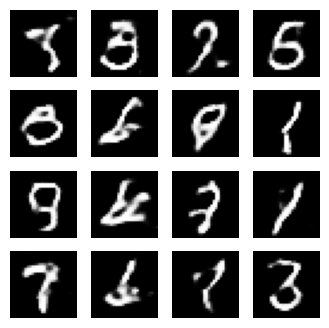

In [31]:
generate_images(generator,seed)